# Learning parameter visulaizer


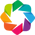

In [1]:
import glob
import os 
import shutil
import numpy as np
import pandas as pd
from operator import mul, add
from matplotlib import pyplot as plt
import IPython
import holoviews as hv
hv.extension('bokeh')
%matplotlib inline

### 言語モジュール

In [8]:
#パラメータ
###############################################
# numOfRepeat = 5        #繰り返し学習する回数
numOfAllConc = 7        #助詞を含んだ概念クラスの数
numOfConc = 3           #助詞を除いた概念クラスの数
threshold = 0.008       #相互情報量の閾値
################################################
ALPHA_WORD = 0.1
NUM_OF_CONC = numOfConc
NUM_OF_TAGS = numOfAllConc
NUM_OF_ALL_TAGS = NUM_OF_TAGS + 2
ALPHA_TAG  = 0.1 * 1.0 / (NUM_OF_ALL_TAGS)
def LoadAndCalcHMMParams(Nyy, Nyx):

    # 文頭・文末を含んだ状態数
    numOfAllPossibleStates = Nyy.shape[0]

    # 文頭・文末を含まない状態数
    numOfStates = numOfAllPossibleStates - 2

    # 辞書内の単語数
    numOfWords = Nyx.shape[1]

    """
    # 初期遷移確率を文頭・文末以外の状態で均等
    initProb = [0.0] * numOfAllPossibleStates
    for i in range(1, numOfStates+1):
        initProb[i] = 1.0/numOfStates
    """

    # 遷移・出力確率の計算
    transitionProb = np.zeros( Nyy.shape )
    emissionProb   = np.zeros( Nyx.shape )

    # 遷移確率
    for i in range(numOfAllPossibleStates-1):
        sum_i = sum(Nyy[i, :]) + NUM_OF_TAGS * ALPHA_TAG
        for j in range(1, numOfAllPossibleStates):
            transitionProb[i, j] = (Nyy[i, j] + ALPHA_TAG) / sum_i

    # 出力確率
    for i in range(1, numOfAllPossibleStates):
        #sum_i = sum(Nyx[i, :]) + numOfWords * ALPHA_WORD
        sum_i = sum(Nyx[i, :]) + ALPHA_WORD
        for j in range(numOfWords):
            emissionProb[i, j] = (Nyx[i, j] + ALPHA_WORD*(1.0/numOfWords)) / sum_i
            #emissionProb[i, j] = (Nyx[i, j] + ALPHA_WORD) / sum_i

    #return initProb, transitionProb, emissionProb
    return transitionProb, emissionProb

In [59]:
import pydot
from IPython.display import display
import IPython.display

index_name = []
index_name.append("start")
index_name.extend(["concept_{0}".format(i) for i in range(numOfConc)] )
index_name.extend( ["particles_{0}".format(i) for i in range(numOfAllConc - numOfConc)] )
index_name.append("stop")

def make_graph(trans_prob, threshold, index_name ):
    trans_prob = trans_prob > threshold

    edges = []
    N = trans_prob.shape[0]

    for i in range(N):
        for j in range(N):
            if trans_prob[i][j]:
                pair = ( index_name[i], index_name[j] )
                edges.append( pair )
    print type(pair[0])
    g=pydot.graph_from_edges(edges,directed=True)
    g.write_png("./tmp.png")
    return hv.RGB.load_image("./tmp.png")

In [60]:
word_list_df = pd.read_csv('../LearnData/wordlist.txt',header=-1)
# word_list_df.columns = ["word"]

wordlist = []
for i in range(len(word_list_df)):
    wordlist.append(word_list_df.iloc[i][0])
wordlist.append("BOS")
wordlist.append("EOS")

In [64]:
def bhmm_graph(threshold,head_num):
    Nyy = np.loadtxt("../result/Nyy.txt")
    Nyx = np.loadtxt("../result/Nyx.txt")
    transitionProb, emissionProb = LoadAndCalcHMMParams(Nyy, Nyx)

    emission_df = pd.DataFrame(emissionProb).T
    word_list_df = pd.DataFrame(wordlist)
    tmp_df = pd.concat([word_list_df,emission_df],axis=1)
    tmp_df_columns = ["word"]
    tmp_df_columns.extend(index_name)
    tmp_df.columns = tmp_df_columns
#     tmp_df.columns = ['word',"start","object","motion","place","particles1","particles2","particles3","particles4","stop"]

    graph = []
    tmp_list = []
    tmp_list.extend(["concept_{0}".format(i) for i in range(numOfConc)] )
    tmp_list.extend( ["particles_{0}".format(i) for i in range(numOfAllConc - numOfConc)] )
    for idx in tmp_list:
        data = tmp_df.sort_values(by=idx,ascending=False).head(head_num)[['word',idx]]
        data.columuns = [['word','prob']]
        graph.append(hv.Bars(data,label=idx))
    graph.append(make_graph(transitionProb,threshold,index_name))
    return reduce(add,graph).cols(2)

In [65]:
hv.extension('matplotlib')

<type 'str'>


:Layout
   .Bars.Concept_0   :Bars   [word]   (concept_0)
   .Bars.Concept_1   :Bars   [word]   (concept_1)
   .Bars.Concept_2   :Bars   [word]   (concept_2)
   .Bars.Particles_0 :Bars   [word]   (particles_0)
   .Bars.Particles_1 :Bars   [word]   (particles_1)
   .Bars.Particles_2 :Bars   [word]   (particles_2)
   .Bars.Particles_3 :Bars   [word]   (particles_3)
   .RGB.I            :RGB   [x,y]   (R,G,B,A)
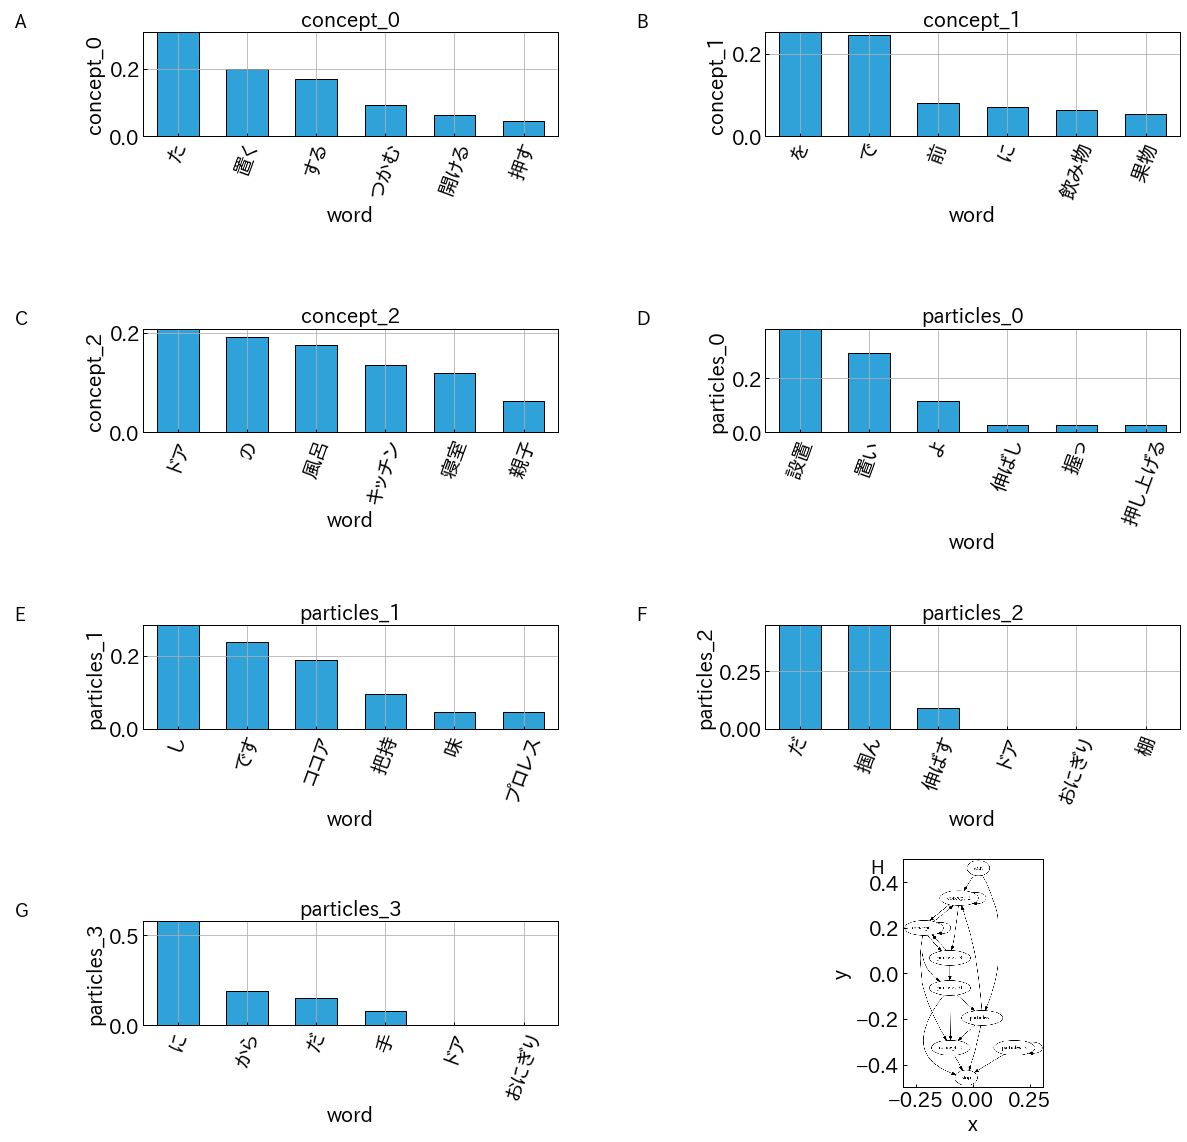

In [66]:
%%output size=200
%%opts Bars [aspect=4 fontsize=20 xrotation=70 show_frame=True show_grid=True] (cmap='Reds' align="edge")
%%opts RGB [height=400 width=400]
bhmm_graph(0.05,6)

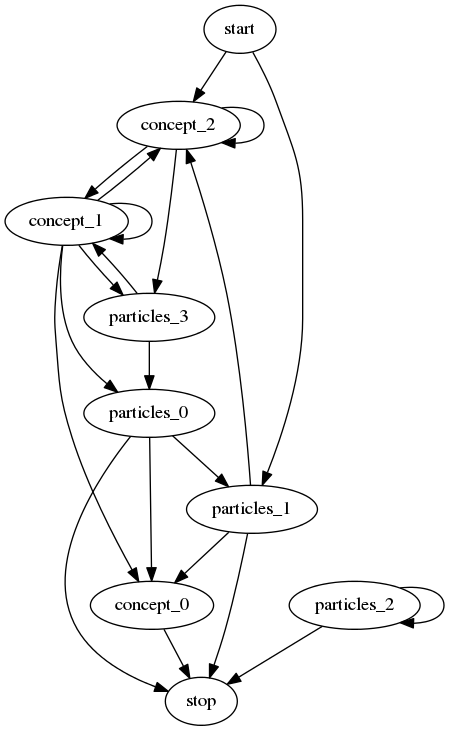

In [67]:
IPython.display.Image("./tmp.png")


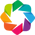

In [68]:
hv.extension('bokeh')

In [69]:
%%output size=150
%%output dpi=100
%%opts HeatMap [height=400 width=400 tools=['hover'] colorbar=True toolbar='above' ] (cmap='Blues')
bhmm_transition_map()

:HeatMap   [x,y]   (z)

In [70]:
word_list_df = pd.read_csv('../LearnData/wordlist.txt',header=-1)
# word_list_df.columns = ["word"]

wordlist = []
for i in range(len(word_list_df)):
    wordlist.append(word_list_df.iloc[i][0])
wordlist.append("BOS")
wordlist.append("EOS")

def bhmm_emission_map():
    Nyy = np.loadtxt( "../result/Nyy.txt")
    Nyx = np.loadtxt( "../result/Nyx.txt")
    transitionProb, emissionProb = LoadAndCalcHMMParams(Nyy, Nyx)
#     data = [(index_name[i],wordlist[j],emissionProb[i,j]) for i in range(emissionProb.shape[0]) for j in range(emissionProb.shape[1])]
    data = [(index_name[i],wordlist[j],emissionProb[i,j]) for i in range(emissionProb.shape[0]) for j in range(len(wordlist))]

    return hv.HeatMap(data).redim.range(z=(0, 0.3))


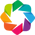

In [71]:
hv.extension('bokeh')

In [72]:
%%output size=150
%%output dpi=100
%%opts HeatMap [height=800 width=400 tools=['hover'] colorbar=True toolbar='above' ] (cmap='Blues')
bhmm_emission_map()

:HeatMap   [x,y]   (z)